<a href="https://colab.research.google.com/github/Hainexx/FOREX-Forecasting-with-Prophet/blob/main/FOREX_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FORECASTING FOREX VIA TS ANALYSIS**
2021/06/20\
Gaspare Mattarella


## Part 1: New Extra Regressors



Beside the regressors we learned from the lab, we choose other candidate extra regressors according to the research references:
- US unemployment
- US interest
- EU interest
- EU repo
- Live data of Covid for EU and US

In [ ]:
# *IMPORT LIBRARIES USED*

!pip install fbprophet
!pip install yfinance

from fbprophet import Prophet
from datetime import date
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time
import plotly.graph_objects as go

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
# Errors
def calc_errors(test, preds):
    percentiles = [5, 25, 50, 75, 95]
    elementwise_mae = np.absolute(np.subtract(preds, test))
    # Mean mae
    mean_mae = sum(elementwise_mae) / len(test)
    print(f"Mean MAE: {mean_mae:.2f}")
    percent_mae = sum(elementwise_mae) / sum(test)
    print(f"MAE%: {percent_mae * 100:.2f}%")
    # Rmse
    rmse = np.sqrt(np.mean(np.power(np.subtract(preds, test), 2)))
    print(f"RMSE: {rmse:.2f}")
    # Bias
    bias = np.mean(np.subtract(preds, test))
    print(f"Bias: {bias:.2f}\n")
    # Mae distrib
    distr_mae = []
    for perc in percentiles:
        temp_mae = np.percentile(elementwise_mae, perc)
        distr_mae.append(temp_mae)
        print(f"{perc}th percetile MAE: {temp_mae:.2f}")
    # Plot MAE distribution
    plt.figure(figsize=(8, 8))
    plt.title('MAE distribution')
    plt.xlabel('MAE')
    plt.ylabel('Count')
    # Plot distr
    plt.hist(elementwise_mae, bins=30)
    # plot mean MAE
    plt.axvline(x=mean_mae, label='Mean MAE', c='r', linestyle='-')
    # plot percentiles
    line_types = [':', '-.', '--', '-.', ':']
    for xc, lt, p in zip(distr_mae, line_types, percentiles):
        plt.axvline(x=xc, label='{}th percentile MAE'.format(p), c='r', linestyle=lt)
    plt.legend()
    plt.show()

In [ ]:
start = pd.to_datetime('2010-01-01')
end = date.today()

### Data from Yahoo Finance

In [ ]:
# In yfinance
tickers_to_download = ['EURUSD=X', 'GBPUSD=X', 'USDCHF=X', 'USDJPY=X', 'EURJPY=X', 'USDCAD=X', 'AUDUSD=X']

In [ ]:
forex_df_list = []

for ticker in tickers_to_download:
  ts = yf.download(ticker, start, end)['Close']
  ts = ts.rename(ticker.lower().split('=', 1)[0] + '_close')
  forex_df_list.append(ts)

forex_df = pd.concat(forex_df_list, axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# In order to forecast the series we need to: 1. 

forex_df['ds'] = forex_df.index
forex_df['y'] = forex_df['eurusd_close'].values


### Extra regressors from Lab

In [ ]:
def get_new_data():
    url_extra = 'https://drive.google.com/file/d/1CT91MvzT2-WLK6rTdDu4-vBdj0kyfDP5/view?usp=sharing'
    url_covid = 'https://drive.google.com/file/d/1ZlwZtSdtxlTlP2RUZtYjqpVSiaXMEzXO/view?usp=sharing'

    file_id = url_extra.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df_extra = pd.read_csv(dwn_url, parse_dates=['DATE'])

    file_id = url_covid.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df_covid = pd.read_csv(dwn_url, parse_dates=['date'])

    return df_extra, df_covid

In [ ]:
# extra regressors from LAB
extra_df, df_covid = get_new_data()

extra_df.set_index('DATE',inplace=True)
# remap column name
map_dict = {'CPIAUCSL':'consumer_price_index', 'GDP':'GDP_US', 'T10YIE':'inflation'}
extra_df = extra_df.rename(columns=map_dict)
# group data for each continent and sum the number of new cases
df_covid_g = df_covid.groupby(['continent','date']).agg({'new_cases':'sum'})
extra_df

,consumer_price_index,GDP_US,inflation
DATE,,,
1947-01-01,21.480,243.164,NaN
1947-01-02,21.480,243.164,NaN
1947-01-03,21.480,243.164,NaN
1947-01-04,21.480,243.164,NaN
1947-01-05,21.480,243.164,NaN
...,...,...,...
2021-05-16,266.832,22048.894,2.51
2021-05-17,266.832,22048.894,2.54
2021-05-18,266.832,22048.894,2.52


In [ ]:
# ADDING new dates information to extra_df - CPI & GDP are dummy values - will be dropped before modeling - ONLY INFLATION IS TAKEN
data_missing = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vRAGPsbAGlw1ahNQEm2wfJdXVyPDBPruORMdqeaEHxYMdEMY96INtxwXLnxZHBuU_nU57iwjgIv8RrN/pub?output=csv",parse_dates=['DATE'])
data_missing.set_index('DATE',inplace=True)
data_missing

,consumer_price_index,GDP_US,inflation
DATE,,,
2021-05-21,266.832,22048.894,2.43
2021-05-24,266.832,22048.894,2.44
2021-05-25,266.832,22048.894,2.42
2021-05-26,266.832,22048.894,2.40
2021-05-27,266.832,22048.894,2.42
2021-05-28,266.832,22048.894,2.42
2021-05-31,266.832,22048.894,2.42
2021-06-01,266.832,22048.894,2.46
2021-06-02,266.832,22048.894,2.44


In [ ]:
# NEW INFO WITH extra_df
extra_df_nw = pd.concat([extra_df, data_missing])

### Extra data for US Unemploymnet, US Interest, EU Interest, EU Repo

In [ ]:
# EXTRA REGRESSORS BY RESEARCH - US UNEMPLOYMENT - US INTEREST - EU INTEREST - EU REPO - RATES

us_eu_data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQOMpnxzYuFaD3pyVLxIoZ_UDf_U8Xy_cPCPf2tmxCXTVA2pn6i9nkBRlXkQj-jLZtinM-gCEFbkPuK/pub?output=csv')

#convert to datetimeindex
us_eu_data.index = pd.to_datetime(us_eu_data.DATE, dayfirst=True)

#add new next month for correct resample
idx = us_eu_data.index[-1] + pd.offsets.MonthBegin(1)

us_eu_data = us_eu_data.append(us_eu_data.iloc[[-1]].rename({us_eu_data.index[-1]: idx}))

#resample with forward filling values, remove last helper row
us_eu_data_new = us_eu_data.resample('D').ffill().iloc[:-1]
# us_eu_data_new = us_eu_data.resample('W').ffill().iloc[:-1]

us_eu_data_new.drop('DATE', axis =1, inplace = True)
print (us_eu_data_new)
# us_eu_data

            US_UNRATE  FEDFUNDS  EU_INTEREST  EU_REPO
DATE                                                 
2010-01-01        9.8      0.11         0.43     0.52
2010-01-02        9.8      0.11         0.43     0.52
2010-01-03        9.8      0.11         0.43     0.52
2010-01-04        9.8      0.11         0.43     0.52
2010-01-05        9.8      0.11         0.43     0.52
...               ...       ...          ...      ...
2021-05-27        5.8      0.06         0.01     0.09
2021-05-28        5.8      0.06         0.01     0.09
2021-05-29        5.8      0.06         0.01     0.09
2021-05-30        5.8      0.06         0.01     0.09
2021-05-31        5.8      0.06         0.01     0.09

[4169 rows x 4 columns]


### Live data of Covid

In [ ]:
# FOR COVID LETS TAKE LIVE DATA - IGNORE DATA FROM LAB

covid_daily = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv",parse_dates=['date'])
covid_daily_agg = covid_daily.groupby(['continent','date']).agg({'new_cases':'sum'})

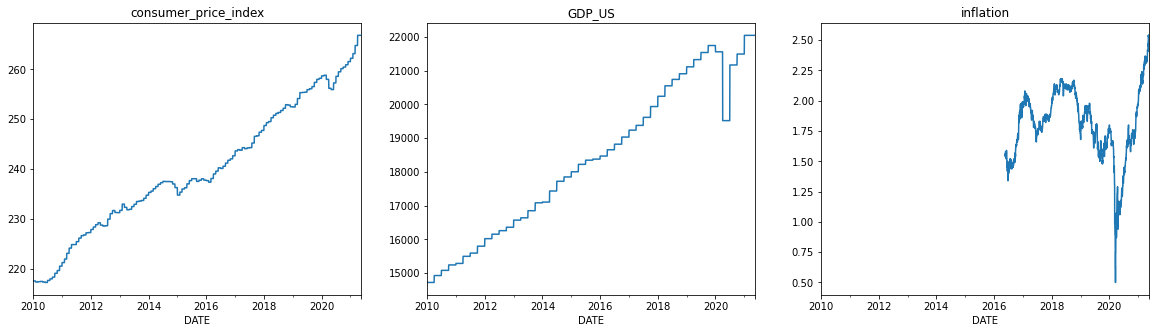

In [ ]:
# plot timeseries
fig, ax = plt.subplots(1,3, figsize=(20,5))
for idx, col in enumerate(extra_df):
  extra_df[col].loc[forex_df.index[0]:forex_df.index[-1]].plot(ax=ax[idx])
  ax[idx].set_title(col)

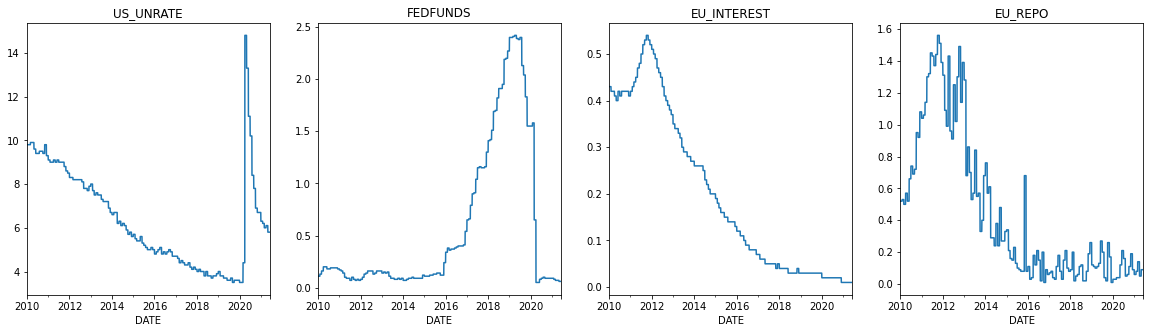

In [ ]:
# plot timeseries - extra regressors
fig, ax = plt.subplots(1,4, figsize=(20,5))
for idx, col in enumerate(us_eu_data_new):
  us_eu_data_new[col].loc[forex_df.index[0]:forex_df.index[-1]].plot(ax=ax[idx])
  ax[idx].set_title(col)

In [ ]:
# merge the data in a single dataframe to explore timeseries correlation
forex_df_reg = forex_df.merge(extra_df_nw, left_index=True, right_index=True, how='left')

forex_df_reg = forex_df_reg.merge(covid_daily_agg.loc['North America'].rename(columns={'new_cases':'covid_US'}), left_index=True, right_index=True, how='left')
forex_df_reg = forex_df_reg.merge(covid_daily_agg.loc['Europe'].rename(columns={'new_cases':'covid_EU'}), left_index=True, right_index=True, how='left')
forex_df_reg['covid_US'] = forex_df_reg['covid_US'].fillna(0)
forex_df_reg['covid_EU'] = forex_df_reg['covid_EU'].fillna(0)
forex_df_reg = forex_df_reg.merge(us_eu_data_new, left_index=True, right_index=True, how='left')
forex_dfn2 = forex_df_reg 


In [ ]:
nlp_regres = pd.read_csv('regressor (1).csv')
nlp_regres = nlp_regres.drop('date.1',axis=1)

In [ ]:
nlp_regres.index = pd.to_datetime(nlp_regres.date, dayfirst=True)
nlp_regres.drop('date',axis=1,inplace=True)

In [ ]:
forex_dfn2 = pd.merge(forex_dfn2, nlp_regres, left_index = True, how='left' ,right_index=True)

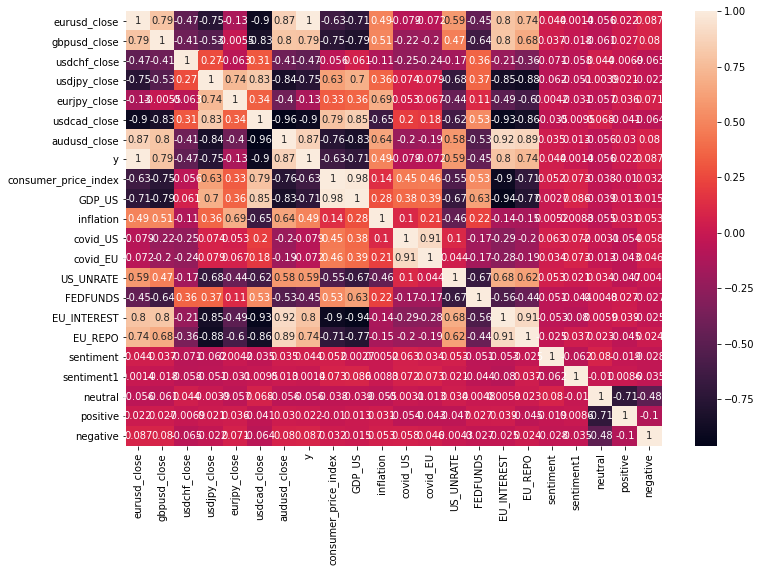

In [ ]:
# explore correlation
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(forex_dfn2.corr(), annot=True, ax=ax)

---
## Part 2: FOREX of 2 consecutive weeks 
Although with regressors we selected the model has a good performance, the forecast is based on the information at the same time. It's kind of "cheating". So to improve the performance, we biuld a ARIMA model to forecast the behavior of the extra regressors first and then use the forecast of the regressors to do the prediction.

In [ ]:
# redefine test and train window
train = forex_dfn2.iloc[:-14,:]
test = forex_dfn2.iloc[-14:,:]
train['ds'] = train.index
train['y'] = train['eurusd_close'].values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
train = train.dropna()
extra_regressor = ['covid_US', 'covid_EU','gbpusd_close','eurjpy_close','consumer_price_index', 'GDP_US', 'inflation',
       'US_UNRATE', 'FEDFUNDS', 'EU_INTEREST', 'EU_REPO','usdcad_close', 'audusd_close','usdjpy_close','sentiment1']
       
regress = train[extra_regressor]
regress

,covid_US,covid_EU,gbpusd_close,eurjpy_close,consumer_price_index,GDP_US,inflation,US_UNRATE,FEDFUNDS,EU_INTEREST,EU_REPO,usdcad_close,audusd_close,usdjpy_close,sentiment1
Date,,,,,,,,,,,,,,,
2018-01-02,0.0,0.0,1.351132,135.440002,248.721,20242.215,2.00,4.0,1.41,0.04,0.09,1.25550,0.780104,112.769997,0.5
2018-01-03,0.0,0.0,1.359619,135.401001,248.721,20242.215,1.98,4.0,1.41,0.04,0.09,1.25039,0.783392,112.244003,0.0
2018-01-04,0.0,0.0,1.351132,135.233994,248.721,20242.215,2.01,4.0,1.41,0.04,0.09,1.25469,0.782840,112.607002,0.0
2018-01-11,0.0,0.0,1.351278,133.237000,248.721,20242.215,2.00,4.0,1.41,0.04,0.09,1.25306,0.784732,111.444000,0.0
2018-01-12,0.0,0.0,1.354188,134.014008,248.721,20242.215,2.01,4.0,1.41,0.04,0.09,1.25190,0.788581,111.293999,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25,37309.0,50746.0,1.415609,132.919998,266.832,22048.894,2.42,5.8,0.06,0.01,0.09,1.20498,0.775080,108.850998,0.0
2021-05-26,37924.0,61391.0,1.414387,133.235992,266.832,22048.894,2.40,5.8,0.06,0.01,0.09,1.20640,0.775314,108.802002,0.0
2021-05-27,43544.0,66718.0,1.411612,133.102005,266.832,22048.894,2.42,5.8,0.06,0.01,0.09,1.21301,0.773990,109.169998,1.0


In [ ]:
# Keeping only columns with regressors
test = test[['ds','y']]
test.shape

(14, 2)

In [ ]:
m = Prophet()
m.fit(train[['ds', 'y']])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(14,freq='B',include_history=False) #ADDING 14 DAYS OF THE TEST SET
future

,ds
0,2021-06-01
1,2021-06-02
2,2021-06-03
3,2021-06-04
4,2021-06-07
5,2021-06-08
6,2021-06-09
7,2021-06-10
8,2021-06-11
9,2021-06-14


In [ ]:
from statsmodels import tsa
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm
import warnings

def lagfor(col,k,future):
  df[col].shift(k)
  regress.iloc[:,col] = regress.iloc[:,col].shift(k)
  yhat = regress.iloc[-14:,]
  future[col.name] = yhat
  return future

def fc_reg(reg,future):
  res = sm.tsa.stattools.arma_order_select_ic(reg, ic='aic',max_ar=6,max_ma=6)
  warnings.filterwarnings('ignore')
  aic = res.aic_min_order
  model = tsa.arima_model.ARMA(reg, order = aic)
  model_fit = model.fit()
  output = model_fit.forecast(14)
  yhat = output[0]
  future[reg.name] = yhat
  return future



In [ ]:
# define Prophet model with hyperparameters
m = Prophet(growth='linear',n_changepoints=7, changepoint_prior_scale=0.05)
# add custom seasonality
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_seasonality(name='weekly', period=7, fourier_order=15)
# add extra regressor

for reg in extra_regressor:
  m.add_regressor(name=reg, mode='additive') #multiplicative   additive

# train model
m.fit(train)

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#future = future.merge(train[extra_regressor], left_on='ds', right_index=True, how='left')
future.shape

(14, 16)

In [ ]:
# make future dataframe and predict
forecast = m.predict(future)
forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_results.set_index('ds', inplace=True)

forecast_results

,yhat,yhat_lower,yhat_upper
ds,,,
2021-06-01,1.218830,1.218181,1.219478
2021-06-02,1.218738,1.218105,1.219380
2021-06-03,1.218726,1.218078,1.219353
2021-06-04,1.218579,1.217940,1.219183
2021-06-07,1.218421,1.217786,1.219036
2021-06-08,1.218266,1.217617,1.218929
2021-06-09,1.218173,1.217526,1.218800
2021-06-10,1.218104,1.217478,1.218759
2021-06-11,1.217905,1.217251,1.218503


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



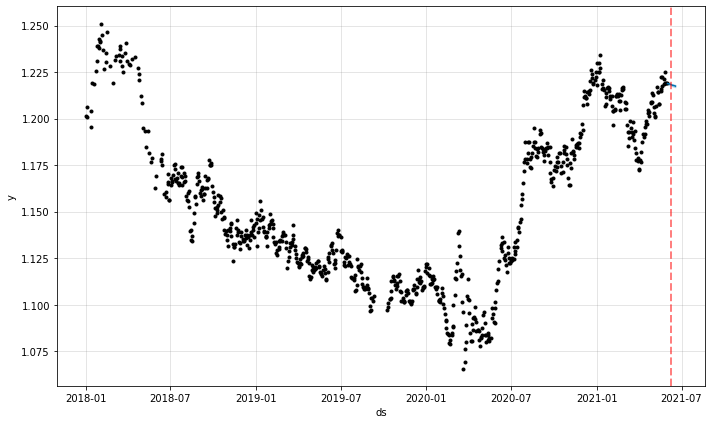

In [ ]:
# Plotting with Prophet built-in method
fig = m.plot(forecast)
ax = fig.add_subplot(111)
ax.axvline(x=forecast['ds'].max() - pd.Timedelta('10 days'), c='red', lw=2, alpha=0.5, ls='--')
fig.show()

In [ ]:
final_df_results = pd.merge(test[['y']], forecast_results[['yhat']], left_index=True, right_index=True, how='inner')
final_df_results

,y,yhat
2021-06-03,1.220986,1.218726
2021-06-04,1.213301,1.218579
2021-06-07,1.216841,1.218421
2021-06-08,1.219363,1.218266
2021-06-09,1.217285,1.218173
2021-06-10,1.218200,1.218104
2021-06-11,1.217256,1.217905
2021-06-14,1.211020,1.217774
2021-06-15,1.212224,1.217671
2021-06-16,1.212709,1.217621


Mean MAE: 0.01
MAE%: 0.65%
RMSE: 0.01
Bias: 0.01

5th percetile MAE: 0.00
25th percetile MAE: 0.00
50th percetile MAE: 0.01
75th percetile MAE: 0.01
95th percetile MAE: 0.02


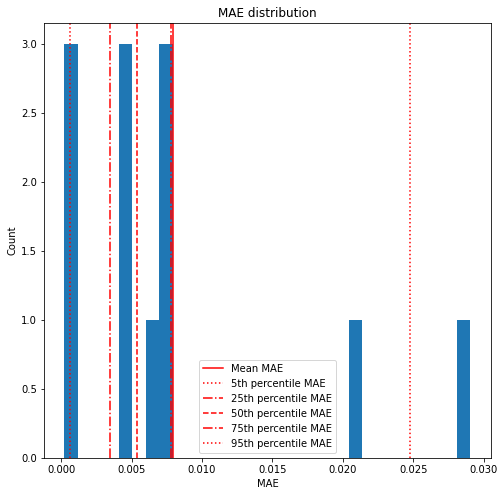

In [ ]:
# Analyze the forecast error
calc_errors(final_df_results['y'].values, final_df_results['yhat'].values)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['y'],
                    mode='lines+markers',
                    name='Real Values'))

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['yhat'],
                    mode='lines+markers',
                    name='Predicted Values'))

fig.update_layout(template='plotly_white')
fig.show()

In [ ]:
extra_regressor = ['eurusd_close','covid_US', 'covid_EU','gbpusd_close','eurjpy_close','consumer_price_index', 'GDP_US', 'inflation',
       'US_UNRATE', 'FEDFUNDS', 'EU_INTEREST', 'EU_REPO']
train_set = forex_dfn2[:'2021-03-01'].iloc[:-1]
train_set= train_set.drop(['eurusd_close','sentiment','sentiment1',	'neutral'	,'positive',	'negative' ,'date.1'],axis = 1)
train_set

,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close,ds,y,consumer_price_index,GDP_US,inflation,covid_US,covid_EU,US_UNRATE,FEDFUNDS,EU_INTEREST,EU_REPO
Date,,,,,,,,,,,,,,,,,
2010-01-01,1.613294,1.03390,92.919998,133.710007,1.05120,0.898473,2010-01-01,1.438994,217.488,14721.350,NaN,0.0,0.0,9.8,0.11,0.43,0.52
2010-01-04,1.611370,1.02910,92.495003,133.389999,1.04100,0.912492,2010-01-04,1.442398,217.488,14721.350,NaN,0.0,0.0,9.8,0.11,0.43,0.52
2010-01-05,1.599079,1.03370,91.584999,131.529999,1.03950,0.911826,2010-01-05,1.436596,217.488,14721.350,NaN,0.0,0.0,9.8,0.11,0.43,0.52
2010-01-06,1.602384,1.02760,92.356003,133.013000,1.03190,0.920471,2010-01-06,1.440403,217.488,14721.350,NaN,0.0,0.0,9.8,0.11,0.43,0.52
2010-01-07,1.593397,1.03360,93.389999,133.748001,1.03400,0.917768,2010-01-07,1.431803,217.488,14721.350,NaN,0.0,0.0,9.8,0.11,0.43,0.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,1.403115,0.89669,105.514000,127.941002,1.25987,0.788849,2021-02-22,1.212636,263.161,22048.894,2.16,66106.0,103446.0,6.2,0.08,0.01,0.08
2021-02-23,1.407123,0.89569,104.984001,127.723000,1.26090,0.791540,2021-02-23,1.216680,263.161,22048.894,2.16,88502.0,134703.0,6.2,0.08,0.01,0.08
2021-02-24,1.412031,0.90510,105.282997,127.919998,1.25926,0.790883,2021-02-24,1.215214,263.161,22048.894,2.17,91134.0,171962.0,6.2,0.08,0.01,0.08


In [ ]:
windows = ['2021-03-01','2021-03-15','2021-04-01']
#'2021-04-15','2021-05-01','2021-05-15','2021-06-01'
MEAN_PRC_MAE = []
MEAN_MAE = []
for window in windows:
  train_set = forex_dfn2[:window].iloc[:-1]
  train_set['ds'] = train_set.index
  train_set['y'] = train_set['eurusd_close'].values
  train_set.fillna(method='pad', inplace=True)
  train_set.dropna(inplace=True)
  extra_regressor = ['gbpusd_close','consumer_price_index', 'GDP_US', 'inflation',
       'US_UNRATE', 'FEDFUNDS', 'EU_INTEREST']
  regress = train_set[extra_regressor]
  test_set = forex_dfn2[window:].iloc[:14]
  test_set = test_set[['ds','y']]
  m = Prophet()
  m.fit(train_set[['ds', 'y']])
  future = m.make_future_dataframe(14,freq='B',include_history=False)
  for col in range(regress.shape[1]):
    fc_reg(regress.iloc[:,col],future)
  m = Prophet(growth='linear', n_changepoints=7, changepoint_prior_scale=0.05)
  m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  m.add_seasonality(name='weekly', period=7, fourier_order=15)
  for reg in extra_regressor:
    m.add_regressor(name=reg, mode='additive')
  m.fit(train_set)
  forecast = m.predict(future)
  forecast_results = forecast[['ds', 'yhat']]
  forecast_results.set_index('ds', inplace=True)
  final_df_results = pd.merge(test_set[['y']], forecast_results[['yhat']], left_index=True, right_index=True, how='inner')
  elementwise_mae = np.absolute(np.subtract(final_df_results['y'].values, final_df_results['yhat'].values))
  mean_mae = sum(elementwise_mae) / len(test_set)
  maes = np.append(maes, mean_mae)
  percent_mae = sum(elementwise_mae) / sum(test_set['y'])
  maes_2 = np.append(maes_2, percent_mae)

MEAN_PRC_MAE =np.average(maes_2)
MEAN_MAE = np.average(maes)
print(f"MAE%: {MEAN_PRC_MAE * 100:.2f}%")
print(f"Mean MAE: {MEAN_MAE:.2f}")

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ValueError: ignored

In [ ]:
sum(test['y'])

16.926372528076172

In [ ]:
elementwise_mae = np.absolute(np.subtract(final_df_results['y'].values, final_df_results['yhat'].values))
mean_mae = sum(elementwise_mae) / len(test)
mean_mae

0.006795069433346687

## Now let's finally forecast the actual next 14 days 

In [ ]:
extra_regressor = ['covid_US', 'covid_EU','gbpusd_close','eurjpy_close','consumer_price_index', 'GDP_US', 'inflation',
       'US_UNRATE', 'FEDFUNDS', 'EU_INTEREST', 'EU_REPO','usdcad_close', 'audusd_close','usdjpy_close']

In [ ]:
# define test and train window
train_window =  ['2010-01-03','2021-06-11']
test_window = ['2021-06-14']
test = forex_dfn2.loc[test_window[0]:]
test = test[['ds','y']]
forex_dfn2 = forex_dfn2[:train_window[1]]

In [ ]:
test

,ds,y
Date,,
2021-06-14,2021-06-14,1.211020
2021-06-15,2021-06-15,1.212224
2021-06-16,2021-06-16,1.212709
2021-06-17,2021-06-17,1.199559
2021-06-18,2021-06-18,1.191341
2021-06-21,2021-06-21,1.190051


In [ ]:
forex_dfn2 = forex_dfn2.fillna(method='ffill')
forex_dfn2 = forex_dfn2.dropna()
regressors = forex_dfn2[extra_regressor]
m = Prophet()
m.fit(forex_dfn2[['ds', 'y']])
m = Prophet(growth='linear',n_changepoints=7, changepoint_prior_scale=0.05)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_seasonality(name='weekly', period=7, fourier_order=15)
for reg in extra_regressor:
  m.add_regressor(name=reg, mode='additive') 
m.fit(forex_dfn2)
future = m.make_future_dataframe(14,freq='B',include_history=False) #ADDING 14 DAYS OF THE TEST SET
for col in range(regressors.shape[1]):
  fc_reg(regressors.iloc[:,col],future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/sta

## Here they are!

In [ ]:
forecast = m.predict(future)
forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_results.set_index('ds', inplace=True)

forecast_results

,yhat,yhat_lower,yhat_upper
ds,,,
2021-06-14,1.216847,1.215754,1.217988
2021-06-15,1.216502,1.215346,1.217631
2021-06-16,1.216122,1.214969,1.217173
2021-06-17,1.215865,1.214711,1.217022
2021-06-18,1.215454,1.214239,1.216544
2021-06-21,1.214988,1.213940,1.216186
2021-06-22,1.214532,1.213449,1.215767
2021-06-23,1.214134,1.213011,1.215264
2021-06-24,1.213850,1.212740,1.214962


In [ ]:
final_df_results = pd.merge(test['y'], forecast_results[['yhat']], left_index=True, right_index=True, how='left')
final_df_results

,y,yhat
Date,,
2021-06-14,1.211020,1.216847
2021-06-15,1.212224,1.216502
2021-06-16,1.212709,1.216122
2021-06-17,1.199559,1.215865
2021-06-18,1.191341,1.215454
2021-06-21,1.190051,1.214988


In [ ]:
# explore results on the forecast window
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['y'],
                    mode='lines+markers',
                    name='Real Values'))

fig.add_trace(go.Scatter(x=forecast_results.index, y=forecast_results['yhat'],
                    mode='lines+markers',
                    name='Predicted Values'))

fig.update_layout(template='plotly_white')
fig.show()

Mean MAE: 0.01
MAE%: 0.89%
RMSE: 0.01
Bias: 0.01

5th percetile MAE: 0.00
25th percetile MAE: 0.00
50th percetile MAE: 0.01
75th percetile MAE: 0.02
95th percetile MAE: 0.02


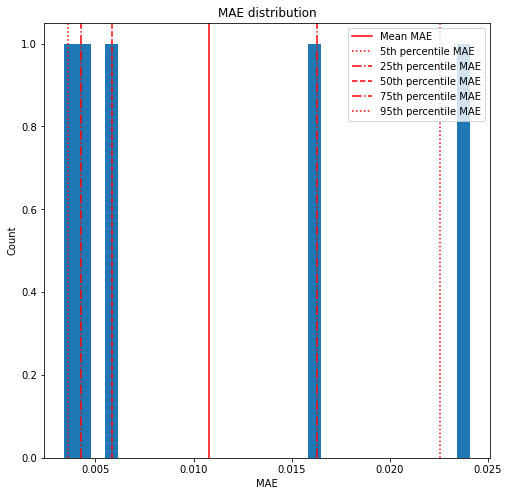

In [ ]:
calc_errors(final_df_results['y'].iloc[:5].values, final_df_results['yhat'].iloc[:5].values)